In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sys
import optax
from optax import warmup_cosine_decay_schedule, cosine_decay_schedule
sys.path.insert(0,"../")

from src.masked.lddmm import registration,Shooting,Flowing,DeformationGradient
from src.masked.kernel import VFTSGaussKernel,TSGaussGaussKernel,TSGaussDotKernel
from src.masked.loss import VarifoldLoss
from src.plotting import plot2Dfigure
from src.masked.barycenter import batch_barycenter_registration
from src.utils import batch_dataset

(array([0.00010036, 0.00030108, 0.00069815, 0.00150976, 0.00323332,
        0.00485653, 0.00426746, 0.00328132, 0.00272716, 0.00270534,
        0.00236936, 0.00217737, 0.00172793, 0.00148358, 0.00135267,
        0.00128722, 0.00128286, 0.00131776, 0.00116504, 0.00099923,
        0.00092505, 0.00093378, 0.00090324, 0.00076797, 0.00074179,
        0.00080288, 0.00084215, 0.00070252, 0.00056725, 0.00045816,
        0.00044507, 0.0005847 , 0.00047125, 0.00041017, 0.00053671,
        0.00049743, 0.00038835, 0.00049307, 0.0005018 , 0.00047562,
        0.00048434, 0.00044507, 0.0004058 , 0.00044071, 0.00041017,
        0.00042762, 0.00041889, 0.00041017, 0.00038398, 0.00043635]),
 array([ 100.,  118.,  136.,  154.,  172.,  190.,  208.,  226.,  244.,
         262.,  280.,  298.,  316.,  334.,  352.,  370.,  388.,  406.,
         424.,  442.,  460.,  478.,  496.,  514.,  532.,  550.,  568.,
         586.,  604.,  622.,  640.,  658.,  676.,  694.,  712.,  730.,
         748.,  766.,  784.,  802.

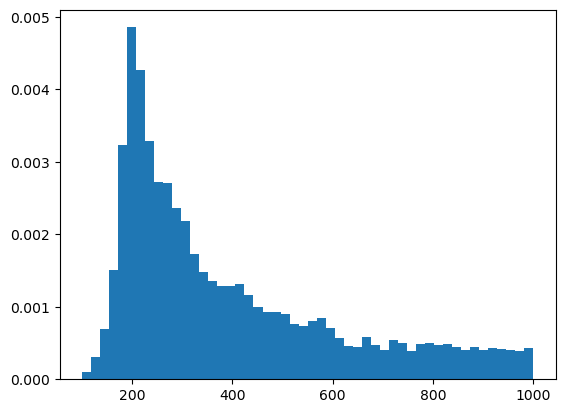

In [2]:
y =pd.read_csv("./dataset/y.csv",index_col=0)
X = np.load("./dataset/X.npy")
X_mask = np.load("./dataset/X_mask.npy")
X = X[:,::2,:]
X_mask = X_mask[:,::2,:]
plt.hist(np.sum(X_mask.squeeze(),-1),density=True,bins=50)

(array([ 313., 1265., 1479., 1274.,  957.,  729.,  550.,  533.,  496.,
         472.]),
 array([ 103. ,  192.7,  282.4,  372.1,  461.8,  551.5,  641.2,  730.9,
         820.6,  910.3, 1000. ]),
 <BarContainer object of 10 artists>)

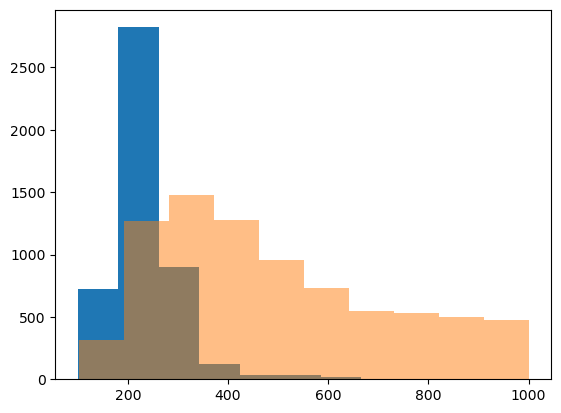

In [3]:
plt.hist(np.sum(X_mask[y.before == "Y"].squeeze(),axis=-1))
plt.hist(np.sum(X_mask[y.before == "N"].squeeze(),axis=-1),alpha=0.5)

In [4]:
lst = []
for filename in y[y.genotype.isin(["colq","wt"])].filename.unique(): 
    idx = y[(y.before == "Y")*(y.filename == filename)].sample(1).index
    lst.append(idx)
    idx = y[(y.before == "N")*(y.filename == filename)].sample(1).index
    lst.append(idx)
idxs = np.concatenate(lst)
X,X_mask = X[idxs],X_mask[idxs]

In [29]:
#schedule = warmup_cosine_decay_schedule(0,1.0,40,300,0.)
schedule = warmup_cosine_decay_schedule(0,0.3,100,800,0)
#schedule = cosine_decay_schedule(0.3,400,0)

iteration:  1 / 800  -- loss:  15074.22
iteration:  10 / 800  -- loss:  14937.13
iteration:  20 / 800  -- loss:  14475.36
iteration:  30 / 800  -- loss:  13438.46
iteration:  40 / 800  -- loss:  10555.42
iteration:  50 / 800  -- loss:  8706.71
iteration:  60 / 800  -- loss:  7633.91
iteration:  70 / 800  -- loss:  7207.30
iteration:  80 / 800  -- loss:  6837.16
iteration:  90 / 800  -- loss:  6565.45
iteration:  100 / 800  -- loss:  6192.36
iteration:  110 / 800  -- loss:  5877.87
iteration:  120 / 800  -- loss:  5563.10
iteration:  130 / 800  -- loss:  5272.17
iteration:  140 / 800  -- loss:  5019.72
iteration:  150 / 800  -- loss:  4784.03
iteration:  160 / 800  -- loss:  4611.09
iteration:  170 / 800  -- loss:  4442.44
iteration:  180 / 800  -- loss:  4278.17
iteration:  190 / 800  -- loss:  4119.88
iteration:  200 / 800  -- loss:  3911.74
iteration:  210 / 800  -- loss:  3710.87
iteration:  220 / 800  -- loss:  3506.80
iteration:  230 / 800  -- loss:  3293.96
iteration:  240 / 800 

(<Figure size 1000x500 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

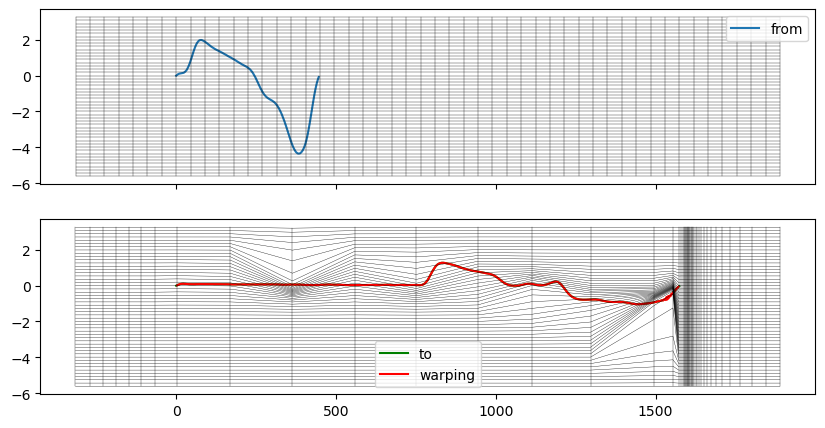

In [31]:
Kv = VFTSGaussKernel(1,0.1,150,1,1)
Kl = TSGaussGaussKernel(5,1,5,0.6)
dataloss = VarifoldLoss(Kl)

p,q0,q0_mask = registration(X[0],X_mask[0],X[-1],X_mask[-1],Kv,dataloss,niter=800,optimizer=optax.adabelief(learning_rate=schedule),gamma_loss=1e-4)

shoot = Shooting(Kv)
flow = Flowing(Kv)
plot2Dfigure(X[0],X[-1],p,shoot,flow,X_mask[0],X_mask[-1])

In [12]:
bX,bX_mask = batch_dataset(X[:10],1,X_mask[:10])
p0s,q0,q0_mask = batch_barycenter_registration(bX,bX_mask,Kv,dataloss,niter=400,optimizer=optax.adabelief(schedule),gamma_loss=1e-4)
plt.plot(*q0.T)

iteration:  1 / 400  -- loss:  4371.20
iteration:  10 / 400  -- loss:  3298.94


KeyboardInterrupt: 